
Viscoplastic thermal convection in a 2-D square box
=======

Benchmarks from Tosi et al. 2015
--------



This notebook generates models from the <a name="ref-1"/>[(Tosi et al., 2015)](#cite-tosi2015community) in Underworld2. The Underworld2 results are compared to the model run on Fenics. Input files for the Fenics models were provided by Petra Maierova.

This example uses the RT PIC solver with classic and nearest neighbour


References
====

<a name="cite-tosi2015community"/><sup>[^](#ref-1) </sup>Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.



Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [99]:
#!pip install natsort
#!pip install networkx

In [100]:
import networkx as nx
import underworld as uw
import math
from underworld import function as fn
import glucifer
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict


from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [101]:
#Display working directory info if in nb mode
if (len(sys.argv) > 1):
    if (sys.argv[1] == '-f'):
        !pwd && ls

/Users/dansandiford/Documents/programming/earthsci_code/python/vueesc/crust_resolution
8100              base_model.py     results
base_model.ipynb  raijin_single.pbs


In [102]:
############
#Model name.  
############
Model = "R"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])


In [103]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so not procs run the check in the next cell too early 

In [104]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False
        

        

results/T/0/Base/checkpoint/ is empty


Set physical constants and parameters, including the Rayleigh number (*RA*). 

In [105]:
###########
#Physical parameters
###########

#The Slippy rheology class will contain dimensional and nondimensional values, linked in a self-consistent way by scaling paramters
#lowermantle.nondimensional['cohesion']
#Where lowermantle is a material class (generated within a rheology class); and non dimensional is a dictionary

#UW naming conventions: 
#module_name, package_name, ClassName, function_name, method_name, 
#ExceptionName, propertyName GLOBAL_CONSTANT_NAME, globalVarName, instanceVarName, functionParameterName, localVarName
###########


newvisc= math.exp(math.log(1e5)*0.53) #A factor that appears because I rescale the reference viscosity, compared to the one used in Tosi et al.
#Where 1e5 = ETAT, and 0.53 is the steady state average temp of the system 

#dimensional parameter dictionary
dp = edict({'LS':2890.*1e3,
           'rho':3300,
           'g':9.81, 
           'kappa':10**-6,
           'alpha':1.25*10**-5, 
           'deltaT':2500})

#non-dimensional parameter dictionary
ndp = edict({'RA':1e2*newvisc, 
              'LS':1., 
              'etaT':1e5, 
              'etaY':10., 
              'eta0':1e-3*newvisc, 
              'TS':0.,
              'TB':1., 
              'cohesion':4.6*newvisc}) #4.6 is the transistion from periodic to stagnant lid.


#dimsional values used in this model
D = dp.LS
g = dp.g
rho = dp.rho
a = dp.alpha
kappa = dp.kappa
dT = dp.deltaT

#nondimensional values used in this model
#RA  = nondim.RA      # Rayleigh number
#TS  = nondim.TS          # surface temperature
#TB  = nondim.TB           # bottom boundary temperature (melting point)
#ETA_T = nondim.etaT
#ETA_Y = nondim.etaY
#ETA0 = nondim.eta0
#YSTRESS = nondim.cohesion

#A few paramters defining lengths scales, affects materal transistions etc.
MANTLETOCRUST = (18.*1e3)/D #Crust depth
CRUSTTOMANTLE = (300.*1e3)/D
LITHTOMANTLE = (660.*1e3)/D
MANTLETOLITH = (200.*1e3)/D
TOPOHEIGHT = (15.*1e3)/D #rock-air topography limits
AVGTEMP = 0.53 #Used to define lithosphere



#Compositional Rayliegh number of rock-air
ETAREF = rho*g*a*dT*((D*1e3)**3)/(ndp.RA*kappa) #equivalent dimesnional reference viscosity
RC = (3300*g*(D*1000)**3)/(ETAREF *kappa) #Composisitional Rayleigh number for rock-air buoyancy force
COMP_RA_FACT = RC/ndp.RA


#Additional dimensionless paramters
AIRVISCOSITY = 0.001
AIRDENSITY = ndp.RA*COMP_RA_FACT



In [106]:
###########
#Model setup parameters
###########

stickyAir = False

MINX = -1.
MINY = 0.
MAXX = 1.0

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 96




#######################To be replaced soon
#Physical parameters that can be defined with STDIN,
#The == '-f': check is a a hack check to see cover the notebook case


if len(sys.argv) == 1:
    RES = RES
elif sys.argv[1] == '-f':
    RES = RES
else:
    RES = int(sys.argv[1])

if MINX == 0.:
    Xres = RES
else:
    Xres = 2*RES

Yres = RES


periodic = [False,False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"

refineMesh = False

s = 1.2 #Mesh refinement parameter
ALPHA = 11. #Mesh refinement parameter

#System/Solver stuff

PIC_integration=False

In [107]:
###########
#Model Runtime parameters
###########

swarm_update = 25
swarm_repop = 25
files_output = 1e6
gldbs_output = 1000
images_output = 1e6
checkpoint_every = 200
metric_output = 100
sticky_air_temp = 1e6

comm.Barrier() #Barrier here so not procs run the check in the next cell too early 

assert metric_output <= checkpoint_every, 'Checkpointing should run less or as ofen as metric output'
assert (metric_output >= swarm_update), 'Swarm update is needed before checkpointing'
#assert metric_output >= sticky_air_temp, 'Sticky air temp should be updated more frequently that metrics'


In [108]:
###########
#Model output parameters
###########

#Do you want to write hdf5 files - Temp, RMS, viscosity, stress?
writeFiles = True
loadTemp = True

    

In [109]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)



velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [110]:
Xres, MINX, periodic, elementType

(192, -1.0, [False, False], 'Q1/dQ0')

Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

Create some dummy fevariables for doing top and bottom boundary calculations.

##Refine mesh

#ICs and BCs

In [111]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

# Setup temperature initial condition via numpy arrays
A = 0.01
#Note that width = height = 1
tempNump = temperatureField.data
for index, coord in enumerate(mesh.data):
    pertCoeff = (1- coord[1]) + A*math.cos( math.pi * abs(1. - coord[0]) ) * math.sin( math.pi * coord[1] )
    tempNump[index] = pertCoeff;
    if coord[1] > 1:
        tempNump[index] = 0.

In [112]:

#For notebook runs
#ModIt = "96"

## Temp ICs

In [113]:
dummymesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (128, 64), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)
    
dummytemperatureField = uw.mesh.MeshVariable(mesh=dummymesh, nodeDofCount=1 )

dummytemperatureField.load("8100/temperatureField.hdf5")

In [114]:
if not checkpointLoad:
    for index, coord in enumerate(mesh.data):
        #Don't know mesh partitions in advance, and possible diferent between 'real' and 'dummy' mesh
        try:
            temperatureField.data[index] = dummytemperatureField.evaluate([coord[0], coord[1]])
        except:
            pass


In [115]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
# send boundary condition information to underworld
IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
TWalls = mesh.specialSets["MaxJ_VertexSet"]
BWalls = mesh.specialSets["MinJ_VertexSet"]

In [116]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(IWalls, JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(JWalls,) )

##Add Random 125 K temp perturbation


tempNump = temperatureField.data

#In gerneral we only want to do this on the initial setup, not restarts

if not checkpointLoad:
    for index, coord in enumerate(mesh.data):
        pertCoeff = (0.05*(np.random.rand(1)[0] - 0.5)) #this should create values between [-0.5,0.5] from uniform dist.
        ict = tempNump[index]
        tempNump[index] = ict + pertCoeff

##Reset bottom Dirichlet conds.

In [117]:
# Set temp boundaries 
# on the boundaries
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TB
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TS

In [118]:
#checkdirs

# Particles

In [119]:
###########
#Material Swarm and variables
###########

gSwarm = uw.swarm.Swarm(mesh=mesh)
materialVariable = gSwarm.add_variable( dataType="char", count=1 )
rockIntVar = gSwarm.add_variable( dataType="double", count=1 )
airIntVar = gSwarm.add_variable( dataType="double", count=1 )
lithIntVar = gSwarm.add_variable( dataType="double", count=1 )

varlist = [materialVariable, rockIntVar, airIntVar, lithIntVar]
varnames = ['materialVariable', 'rockIntVar', 'airIntVar', 'lithIntVar']

In [120]:
###########
#Swarms for surface intragrals when using Sticky air
###########

snum = 1000.
dx = (mesh.data[:,0].max()- mesh.data[:,0].min())/snum
yp = 0.9947 #1. - yelsize/2. at res = 96

mesh.data[:,0].max()
xps = np.linspace(mesh.data[:,0].min(),mesh.data[:,0].max(), snum)
yps = [yp for i in xps]

surfintswarm = uw.swarm.Swarm( mesh=mesh )
dumout = surfintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

yps = [ 1.- yp  for i in xps]

baseintswarm = uw.swarm.Swarm( mesh=mesh)
dumout = baseintswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

#Initialise swarm variables, or Swarm checkpoint load

In [121]:
mantleIndex = 0
lithosphereIndex = 1
crustIndex = 2
airIndex = 3


if checkpointLoad:
    checkpointLoadDir = natsort.natsorted(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    # Create the layout object
    #layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=20)
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=15)
    # Now use it to populate.
    gSwarm.populate_using_layout( layout=layout )

    # Lets initialise the 'materialVariable' data to represent different materials
    # Set the material to heavy everywhere via the numpy array
    materialVariable.data[:] = mantleIndex
    
    
    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
                 materialVariable.data[particleID] = airIndex
        elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex


#Material Graphs

In [122]:
##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3]


In [123]:
print( "unique values after swarm has loaded:" + str(np.unique(materialVariable.data[:])))


unique values after swarm has loaded:[0 2]


In [124]:


#All depth conditions are given as (km/D) where D is the length scale, 
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#######Graph object
DG = nx.DiGraph(field="Depth")

#######Nodes
#Note that the order of materials, deepest to shallowest is important 
DG.add_node(0, mat='mantle')
DG.add_node(1, mat='lithosphere')
DG.add_node(2, mat='crust')
DG.add_node(3, mat='air')


labels=dict((n,d['mat']) for n,d in DG.nodes(data=True))
pos=nx.spring_layout(DG) 


#######Edges
#anything to air
DG.add_edges_from([(0,3),(1,3), (2,3)])
DG[0][3]['depthcondition'] = -1*TOPOHEIGHT
DG[1][3]['depthcondition'] = -1*TOPOHEIGHT
DG[2][3]['depthcondition'] = -1*TOPOHEIGHT


#Anything to mantle
DG.add_edges_from([(2,0), (3,0), (1,0)])
DG[3][0]['depthcondition'] = TOPOHEIGHT
DG[2][0]['depthcondition'] = CRUSTTOMANTLE
DG[1][0]['depthcondition'] = LITHTOMANTLE #This means we're going to kill lithosphere at the 660.


#Anything to lithsphere
DG.add_edges_from([(0,1),(3,1)])
DG[0][1]['depthcondition'] = MANTLETOLITH
DG[0][1]['avgtempcondition'] = 0.75*AVGTEMP #definition of thermal lithosphere


#Anything to crust
DG.add_edges_from([(0,2), (1,2)])
DG[0][2]['depthcondition'] = MANTLETOCRUST
DG[1][2]['depthcondition'] = MANTLETOCRUST

In [125]:
DG.nodes()

[0, 1, 2, 3]

In [126]:
remove_nodes = []
for node in DG.nodes():
    if not node in material_list:
        remove_nodes.append(node)
        
for rmnode in remove_nodes:
    DG.remove_node(rmnode)

In [127]:
DG.nodes()

[0, 1, 2, 3]

In [128]:
#A Dictionary to map strings in the graph (e.g. 'depthcondition') to particle data arrays

particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
particletemps = temperatureField.evaluate(gSwarm)[:,0]

conditionmap = {}

conditionmap['depthcondition'] = {}
conditionmap['depthcondition']['data'] = particledepths
conditionmap['avgtempcondition'] = {}
conditionmap['avgtempcondition']['data'] = particletemps

In [129]:
def update_swarm(graph, particleIndex):
    """
    This function takes the materials graph (networkx.DiGraph), and a particle index,
    then determines if a material update is required 
    and if so, returns the new materialindex
    Args:
        graph (networkx.DiGraph): Directed multigraph representing the transformation of material types
        particleIndex (int): the particle index as corressponding to the index in the swarm data arrays
    Returns:
        if update is required the function returns the the new material variable (int) 
        else returns None
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    ##Egde gives links to other materials, we then query the conditions to see if we should change materials
    matId = materialVariable.data[particleIndex][0]
    innerchange = False
    outerchange = False
    for edge in graph[matId]:
        if outerchange:
            break
        for cond in graph[matId][edge].keys():
            outerchange = False
            if innerchange: #found a complete transition, break inner loop
                break
            currentparticlevalue = conditionmap[cond]['data'][particleIndex]
            crossover = graph[matId][edge][cond]
            if ((matId > edge) and (currentparticlevalue > crossover)):
                innerchange = False # continue on, 
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            elif ((matId < edge) and (currentparticlevalue < crossover)):
                innerchange = False
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            else:
                #condition not met, break outer loop, go to next edge, outerchange should still be False
                break
    if type(innerchange) == int:
        return innerchange

In [130]:
#Cleanse the swarm of its sins
#For some Material Graphs, the graph may have to be treaversed more than once

check = -1
number_updated = 1

while number_updated != 0:
    number_updated = 0
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
                check = update_swarm(DG, particleID)
                if check > -1:
                    number_updated += 1
                    materialVariable.data[particleID] = check

##Set the values for the masking swarms

In [131]:
#Setup up a masking Swarm variable for the integrations.
#These should be rebuilt at same frequency as the metric calcualtions

rockIntVar.data[:] = 0.
notair = np.where(materialVariable.data != airIndex)
rockIntVar.data[notair] = 1.

airIntVar.data[:] = 0.
notrock = np.where(materialVariable.data == airIndex)
airIntVar.data[notrock] = 1.

lithIntVar.data[:] = 0.
islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
lithIntVar.data[islith] = 1.


#Material properties


In [132]:
#Make variables required for plasticity

# The yeilding of the upper slab is dependent on the strain rate.
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))


coordinate = fn.input()
depth = 1. - coordinate[1]
depthField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1 )
depthField.data[:] = depth.evaluate(mesh)
depthField.data[np.where(depthField.data[:] < 0.)[0]] = 0.

In [133]:
##Basic mantle viscosity Functions
viscosityl2 = newvisc*fn.math.exp((math.log(ndp.etaT)*-1*temperatureField) + (depthField*math.log(ndp.etaY)))
viscosityFn1 = viscosityl2 #This one always gets passed to the first velcotity solve

#Von Mises effective viscosity
viscosityp = ndp.eta0 + ndp.cohesion/(strainRate_2ndInvariant/math.sqrt(0.5)) #extra factor to account for underworld second invariant form
viscosityFn2 = 2./(1./viscosityl2 + 1./viscosityp)


##Now setup rheolgy for models with crust rheology;

viscreduct = 0.1
crustviscosityp = viscreduct*ndp.eta0+ ((viscreduct*ndp.cohesion)/(strainRate_2ndInvariant/math.sqrt(0.5))) #extra factor to account for underworld second invariant form
crustviscosityFn2 = 2./(1./viscosityl2 + 1./crustviscosityp)

Set up simulation parameters and functions
====

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

In [134]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:AIRVISCOSITY, 
                                    lithosphereIndex:viscosityFn2, 
                                    crustIndex:crustviscosityFn2,
                                    mantleIndex:viscosityFn2} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:AIRDENSITY, 
                                    lithosphereIndex:ndp.RA*temperatureField, 
                                    crustIndex:ndp.RA*temperatureField, 
                                    mantleIndex:ndp.RA*temperatureField} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn

Build the Stokes system, solvers, advection-diffusion
------

Setup linear Stokes system to get the initial velocity.

In [135]:
#We first set up a l
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
#                              viscosityFn=viscosityFn1, 
                              fn_viscosity=fn.exception.SafeMaths(viscosityFn1), 
                              fn_bodyforce=buoyancyFn)

We do one solve with linear viscosity to get the initial strain rate invariant. This solve step also calculates a 'guess' of the the velocity field based on the linear system, which is used later in the non-linear solver.

In [136]:
checkpointLoad

False

In [137]:
if not checkpointLoad:
    solver = uw.systems.Solver(stokesPIC)
    solver.solve() 

In [138]:
#Switch particle escape on, this will also trigger the inflow population control 
gSwarm.particleEscape = True

In [139]:
# Setup the Stokes system again, now with linear or nonlinear visocity viscosity.

if PIC_integration:
    swarm = gSwarm
else:
    swarm = False

stokesPIC2 = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=fn.exception.SafeMaths(viscosityMapFn), 
                              fn_bodyforce=buoyancyFn, swarm = swarm)

In [140]:
solver = uw.systems.Solver(stokesPIC2) # altered from PIC2



#Set more advanced solver option
solver.options.main.Q22_pc_type='uw'
solver.options.A11.ksp_rtol=1e-5
solver.options.scr.ksp_rtol=1e-5
#solver.options.A11.ksp_type="cg"
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1

solver.options.mg.levels = 3

#solver.options.A11.ksp_monitor=''
#solver.options.A11.ksp_converged_reason='

Solve for initial pressure and velocity using a quick non-linear Picard iteration


In [141]:
solver.solve(nonLinearIterate=True)

Create an advective-diffusive system
=====

Setup the system in underworld by flagging the temperature and velocity field variables.

In [142]:
#Create advdiff system



advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField, 
                                         fn_diffusivity = 1.0, 
                                         conditions     = [tempBC,] )



advector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

Metrics for benchmark
=====

Define functions to be used in the time loop. For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temp... $$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers... $$N = \int^1_0 \frac{\partial T}{\partial y} \rvert_{y=0/1} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
* max and min viscosity over the whole domain
* average rate of work done against gravity...$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation...$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

In [143]:
#Setup some Integrals. We want these outside the main loop...
tempVariable = gSwarm.add_variable( dataType="double", count=1 )
tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
tempint = uw.utils.Integral((tempVariable*rockIntVar), mesh)


areaint = uw.utils.Integral((1.*rockIntVar),mesh)

v2int = uw.utils.Integral(fn.math.dot(velocityField,velocityField)*rockIntVar, mesh)


dwint = uw.utils.Integral(temperatureField*velocityField[1]*rockIntVar, mesh)


sinner = fn.math.dot(strainRate_2ndInvariant,strainRate_2ndInvariant)
vdint = uw.utils.Integral((4.*viscosityMapFn*sinner)*rockIntVar, mesh)
vdintair = uw.utils.Integral((4.*viscosityMapFn*sinner)*airIntVar, mesh)
vdintlith = uw.utils.Integral((4.*viscosityMapFn*sinner)*lithIntVar, mesh)

In [144]:
#These should differ if the the map function assigns different properties to bulk mantle

print(uw.utils.Integral((4.*viscosityFn2*sinner)*rockIntVar, mesh).evaluate()[0])
print(uw.utils.Integral((4.*viscosityMapFn*sinner)*rockIntVar, mesh).evaluate()[0])

print(uw.utils.Integral((4.*viscosityFn2*sinner)*airIntVar, mesh).evaluate()[0])
print(uw.utils.Integral((4.*viscosityMapFn*sinner)*airIntVar, mesh).evaluate()[0])

print(uw.utils.Integral((4.*viscosityFn2*sinner)*lithIntVar, mesh).evaluate()[0])
print(uw.utils.Integral((4.*viscosityMapFn*sinner)*lithIntVar, mesh).evaluate()[0])

95776.6543606
93468.6092575
0.0
0.0
10596.8863517
8288.84124856


\begin{equation}  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy \end{equation}

In [145]:
def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

#This one gets cleaned up when Surface integrals are available
def nusselt(tempfield, swarm, dx):
    #Update the swarm variable
    tempgrad = tempfield.fn_gradient
    valcheck = tempgrad[1].evaluate(swarm)
    if valcheck is None:
        vals = np.array(0, dtype='float64')
    else:
        vals = valcheck.sum()*dx
    return vals

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

#This one gets cleaned up when Surface integrals are available
def rms_surf(swarm, dx):
    rmsmaxfn = fn.math.dot(velocityField,velocityField)
    rmscheck = rmsmaxfn.evaluate(swarm)
    if rmscheck is None:
        #print "watch out"
        rmsvals = np.array(0, dtype='float64')
    else:
        rmsvals = np.sqrt(rmscheck.sum()*dx)
        #print "okay"
    return rmsvals

def max_vx_surf(velfield, swarm):
    check = velfield[0].evaluate(swarm)
    if check is None:
        return 0.
    else:
        return check.max()


#def max_vy_surf(velfield, swarm):
#    surfvelxmaxfn = fn.view.min_max(velfield[1])
#    surfvelxmaxfn.evaluate(swarm)
#    return surfvelxmaxfn.max_global()

def gravwork(workfn):
    return workfn.evaluate()[0]

def viscdis(vdissfn):
    return vdissfn.evaluate()[0]

def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(gSwarm)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [146]:
#Fields for saving data / fields

rmsField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
rmsfn = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
rmsdata = rmsfn.evaluate(mesh)
rmsField.data[:] = rmsdata 

viscField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
viscdata = viscosityFn2.evaluate(mesh)
viscField.data[:] = viscdata


strainrateField = uw.mesh.MeshVariable( mesh=mesh,   nodeDofCount=1)
srtdata = fn.tensor.second_invariant( 
                    fn.tensor.symmetric( 
                        velocityField.fn_gradient ))
rostfield = srtdata.evaluate(mesh)
strainrateField.data[:] = rostfield

viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)


In [147]:
#Images
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True))


figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
figMat.append( glucifer.objects.Mesh(mesh))


figStrainRate = glucifer.Figure()
figStrainRate.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True))


figVelocityMag = glucifer.Figure()
figVelocityMag.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField))
)
figTemp = glucifer.Figure()
figTemp.append( glucifer.objects.Surface(mesh, temperatureField))



#Pack some stuff into a database as well
figDb = glucifer.Figure()
figDb.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, arrowHead=0.2, scaling=0.01))
figDb.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, colours='brown white blue'))
                           

In [148]:

pics = uw.swarm.PICIntegrationSwarm(gSwarm)

In [149]:
def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        filename.write((13*'%-15s ' + '\n') % (realtime, Viscdis, float(Nu0glob), float(Nu1glob), Avg_temp, 
                                              Rms,Rmsurfglob,Max_vx_surf,Gravwork, etamax, etamin, Viscdisair, Viscdislith))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
        
    

In [150]:
###########
#Open file for writing metrics
###########

if checkpointLoad:
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    #os.rename(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    realtime = prevdata[prevdata.shape[0]-1, 0]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

Main simulation loop
=======

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.


In [ ]:
# initialise timer for computation
startMain = time.clock()
# Perform steps
while realtime < 0.05:
#while step < 5:
    #Enter non-linear loop
    print step
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    #start = time.clock()
    advDiff.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advDiff time is: " + str(machine_time))
    # Advect swarm using this timestep size
    #start = time.clock()
    advector.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advector time is: " + str(machine_time))
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    
    ################
    #Update temperature field in the air region
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = 0.
 
    ################
    #Particle update
    ###############
    if (step % swarm_update == 0) or (step % metric_output == 0): #These updates should be done before any metric output
        #These swarm variables get updated first, as they are used to determine material changes
        particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
        particletemps = temperatureField.evaluate(gSwarm)[:,0]
        conditionmap['depthcondition']['data'] = particledepths
        conditionmap['avgtempcondition']['data'] = particletemps
        ################
        number_updated = 0
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            check = update_swarm(DG, particleID)
            if check > -1:
                number_updated += 1
                #if check == 0:
                #    print "from " + str(materialVariable.data[particleID]) + " to " + str(check)
                materialVariable.data[particleID] = check
            else:
                pass
        #Also update those integration swarms
        rockIntVar.data[:] = 0.
        notair = np.where(materialVariable.data != airIndex)
        rockIntVar.data[notair] = 1.
        airIntVar.data[:] = 0.
        notrock = np.where(materialVariable.data == airIndex)
        airIntVar.data[notrock] = 1.
        lithIntVar.data[:] = 0.
        islith = np.where((materialVariable.data == lithosphereIndex) | (materialVariable.data == crustIndex))
        lithIntVar.data[islith] = 1.

    ################            
    # Calculate the Metrics, only on 1 of the processors:
    ################
    if (step % metric_output == 0):
        ###############
        #Swarm - based Metrics
        ###############
        tempVariable.data[:] = temperatureField.evaluate(gSwarm)[:]
        Avg_temp = avg_temp()
        Rms = rms()
        Gravwork = gravwork(dwint)
        Viscdis = viscdis(vdint)
        Viscdisair = viscdis(vdintair)
        Viscdislith = viscdis(vdintlith)
        etamax, etamin = visc_extr(viscosityMapFn)
        #These are the ones that need mpi4py treatment
        Nu0loc = nusselt(temperatureField, baseintswarm, dx)
        Nu1loc = nusselt(temperatureField, surfintswarm, dx)
        Rmsurfloc = rms_surf(surfintswarm, dx)
        Max_vx_surfloc = np.array(max_vx_surf(velocityField, surfintswarm),'d') #This float needed to be an array to play with mpi4py
        #Setup the global output arrays
        dTp = Nu0loc.dtype
        Nu0glob = np.array(0, dtype=dTp)
        dTp = Nu1loc.dtype
        Nu1glob = np.array(0, dtype=dTp)
        dTp = Rmsurfloc.dtype
        Rmsurfglob = np.array(0, dtype=dTp)
        dTp = Max_vx_surfloc.dtype
        Max_vx_surfglob = np.array(0.0,dtype=dTp)   
        #Do global operation ... sum, or max
        comm.Allreduce(Nu0loc, Nu0glob, op=MPI.SUM)
        comm.Allreduce(Nu1loc, Nu1glob, op=MPI.SUM)
        comm.Allreduce(Rmsurfloc, Rmsurfglob, op=MPI.SUM)
        comm.Allreduce([Max_vx_surfloc, MPI.DOUBLE],[Max_vx_surfglob, MPI.DOUBLE],op=MPI.MAX)      
        # output to summary text file
        if uw.rank()==0:
            f_o.write((13*'%-15s ' + '\n') % (realtime, Viscdis, float(Nu0glob), float(Nu1glob), Avg_temp, 
                                              Rms,Rmsurfglob,Max_vx_surfglob,Gravwork, etamax, etamin, Viscdisair, Viscdislith))
        #test = max_vx_surf(velocityField, surfintswarm)    
        #if uw.rank()==0:
         #   print(Rmsurfglob,MRms_surf, Max_vx_surfglob, MMax_vx_surf, etamax, Metamax)
        #print(Rmsurfloc, test)
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0) & (writeFiles == True):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        figDb.show()
        figDb.save_database(fullpath)
    ################
    #Also repopulate entire swarm periodically
    ################
    if step % swarm_repop == 0:
        pics.repopulate()
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?
     
    
f_o.close()
#print 'step =',step, '; dt =', dt, '; CPU time =', time.clock()-startMain

8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164


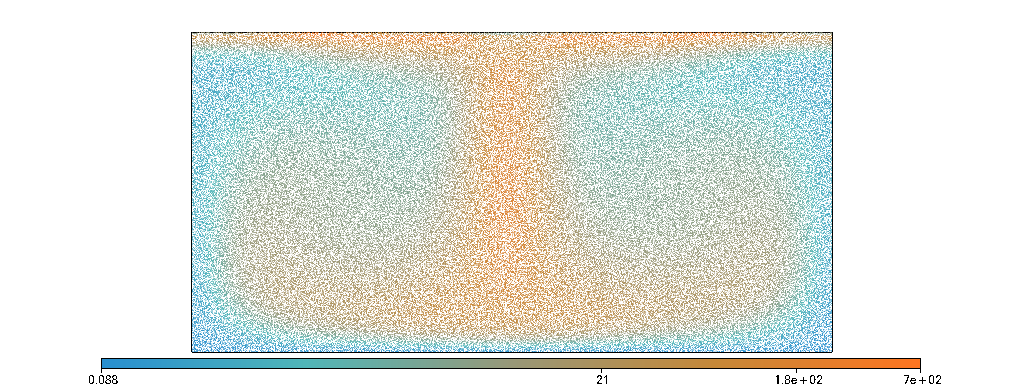

In [152]:
#figEta = glucifer.Figure(figsize=(1024,384))
#figEta.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True))
#figEta.save_database('test.gldb')
#figEta.show()



In [ ]:

##figMat = glucifer.Figure()
#figMat.append( glucifer.objects.Points(gSwarm,materialVariable, colours='brown white blue red'))
#figMat.append( glucifer.objects.Points(surfintswarm,materialVariable, pointSize= 5.))
#figMat.append( glucifer.objects.Mesh(linearMesh))
#figMat.save_database('test.gldb')
#figMat.show()

 


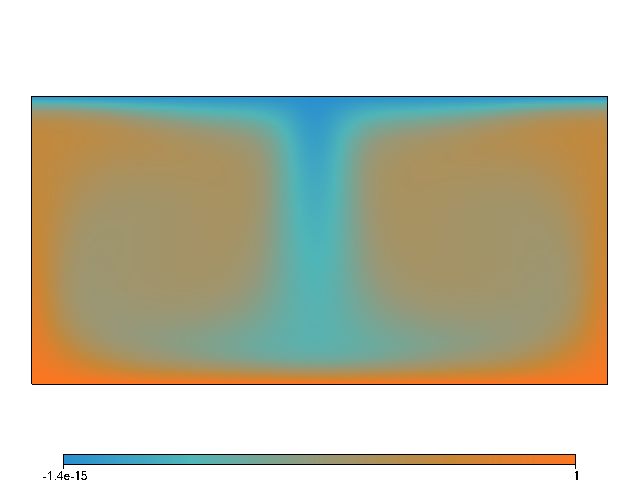

In [46]:
figTemp = glucifer.Figure()
figTemp.append( glucifer.objects.Surface(mesh, temperatureField))
figTemp.show()

In [ ]:
#figStrainRate = glucifer.Figure()
#figStrainRate.append( glucifer.objects.Surface(elementMesh, strainRate_2ndInvariant, logScale=True))
#figStrainRate.show()
#figStrainRate.save_database('test.gldb')


In [ ]:
machine_time = (time.clock()-startMain)
print("total time is: " + str(machine_time))

In [ ]:
velocityField.evaluate(IWalls)[:,1].max()

In [ ]:
velocityField.evaluate(TWalls)[:,0].max()